# Compararea sesiunilor: AI vs NO-AI

În acest notebook analizăm și comparăm două sesiuni de interacțiune gestuală:

- **AI (Hailo ON)**: `session_ai.csv`
- **NO-AI (fără Hailo)**: `session_no_ai.csv`

Scopul este să evaluăm impactul filtrului AI (Hailo-8) asupra:
- performanței (FPS, latență),
- stabilității comenzilor,
- robusteții detecției,
- numărului de landmark-uri MediaPipe.


Import și încărcare CSV-uri

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 5)

# Încarcă fișierele CSV
df_ai = pd.read_csv("session_ai.csv", parse_dates=["timestamp"])
df_noai = pd.read_csv("session_no_ai.csv", parse_dates=["timestamp"])

df_ai.head(), df_noai.head()


C:\Users\Maurice\AppData\Local\Temp\ipykernel_25972\2611997457.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_ai = pd.read_csv("session_ai.csv", parse_dates=["timestamp"])


(            timestamp        fps  frame_time_ms  hailo_score  hailo_valid  \
 0  1763921411.5065575   1.888082     529.638052          0.0            0   
 1  1763921412.0153456  24.294666      41.161299          0.0            0   
 2   1763921412.084312  24.662366      40.547609          0.0            0   
 3  1763921412.1414652  21.313170      46.919346          0.0            0   
 4  1763921412.1947386  22.597647      44.252396          0.0            0   
 
    mediapipe_points     command  tcp_sent  tcp_reconnected   cx   cy  
 0                21  Move Right         1                0  209  177  
 1                21  Move Right         0                0  208  177  
 2                21  Move Right         0                0  208  177  
 3                21  Move Right         0                0  208  177  
 4                21  Move Right         0                0  207  177  ,
                    timestamp         fps  frame_time_ms  hailo_score  \
 0 2025-11-23 21:28:48.5

Curatare + timp relativ

In [11]:
def add_relative_time(df):
    df = df.copy()
    
    # Step 1: Try to interpret the column as Numbers (Unix Timestamps)
    # 'errors="coerce"' turns the text dates into NaNs (Not a Number) temporarily
    numeric_series = pd.to_numeric(df["timestamp"], errors='coerce')
    
    # Step 2: Convert those numbers to Datetimes
    unix_dates = pd.to_datetime(numeric_series, unit='s', errors='coerce')
    
    # Step 3: Convert the original column as Standard Strings
    # This catches the '2025-11-23...' format
    string_dates = pd.to_datetime(df["timestamp"], errors='coerce')
    
    # Step 4: Combine them
    # Use the Unix result; if it's missing (NaT), fill it with the String result
    df["timestamp"] = unix_dates.fillna(string_dates)
    
    # Step 5: Calculate relative time
    # Check if we have valid data before subtraction to avoid new errors
    if not df["timestamp"].isnull().all():
        start_time = df["timestamp"].iloc[0]
        df["t_sec"] = (df["timestamp"] - start_time).dt.total_seconds()
    
    return df

# Run it on your dataframes
df_ai = add_relative_time(df_ai)
df_noai = add_relative_time(df_noai)

# Verify the result
print("Success! Here is the clean data:")
display(df_ai[["timestamp", "t_sec", "fps"]].head())
display(df_ai[["timestamp", "t_sec", "fps"]].tail()) # Check the end to ensure mixed formats worked

Success! Here is the clean data:


C:\Users\Maurice\AppData\Local\Temp\ipykernel_25972\1488034268.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  string_dates = pd.to_datetime(df["timestamp"], errors='coerce')


,timestamp,t_sec,fps
0,2025-11-23 18:10:11.506557703,0.000000,1.888082
1,2025-11-23 18:10:12.015345573,0.508788,24.294666
2,2025-11-23 18:10:12.084311962,0.577754,24.662366
3,2025-11-23 18:10:12.141465187,0.634907,21.313170
4,2025-11-23 18:10:12.194738626,0.688181,22.597647


,timestamp,t_sec,fps
8461,2025-11-27 19:42:18.653517,351127.146959,27.004797
8462,2025-11-27 19:42:18.708144,351127.201586,20.357240
8463,2025-11-27 19:42:18.762938,351127.256380,20.442170
8464,2025-11-27 19:42:18.819214,351127.312656,19.377525
8465,2025-11-27 19:42:18.869679,351127.363121,21.932148


Info de bază despre sesiuni

In [12]:
print("=== INFO SESIUNI ===")
print("AI session:")
print("  N frames:", len(df_ai))
print("  Durata (s):", df_ai["t_sec"].iloc[-1])

print("\nNO-AI session:")
print("  N frames:", len(df_noai))
print("  Durata (s):", df_noai["t_sec"].iloc[-1])


=== INFO SESIUNI ===
AI session:
  N frames: 8466
  Durata (s): 351127.363121297

NO-AI session:
  N frames: 5367
  Durata (s): 339268.307394


FPS în timp (comparativ)

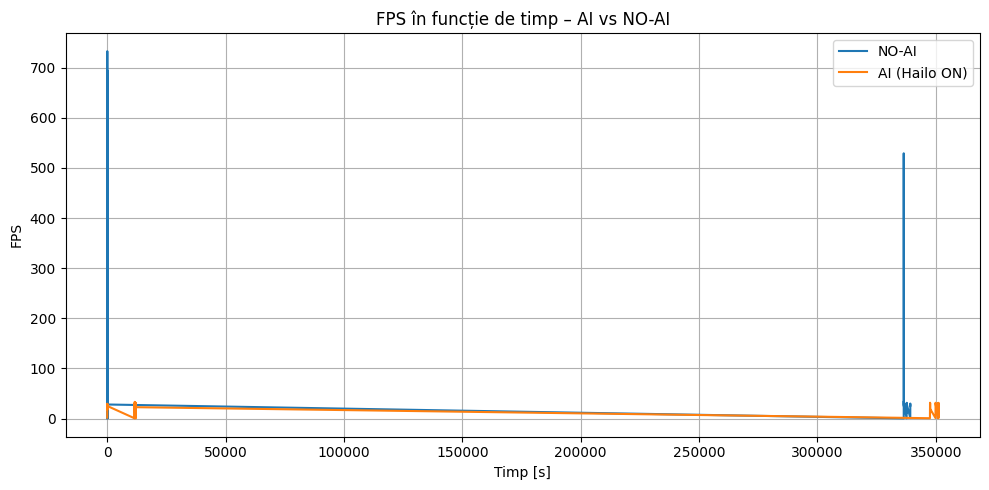

In [13]:
plt.figure()
plt.plot(df_noai["t_sec"], df_noai["fps"], label="NO-AI")
plt.plot(df_ai["t_sec"], df_ai["fps"], label="AI (Hailo ON)")
plt.xlabel("Timp [s]")
plt.ylabel("FPS")
plt.title("FPS în funcție de timp – AI vs NO-AI")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("compare_fps.png", dpi=150)
plt.show()


Latenta per frame 

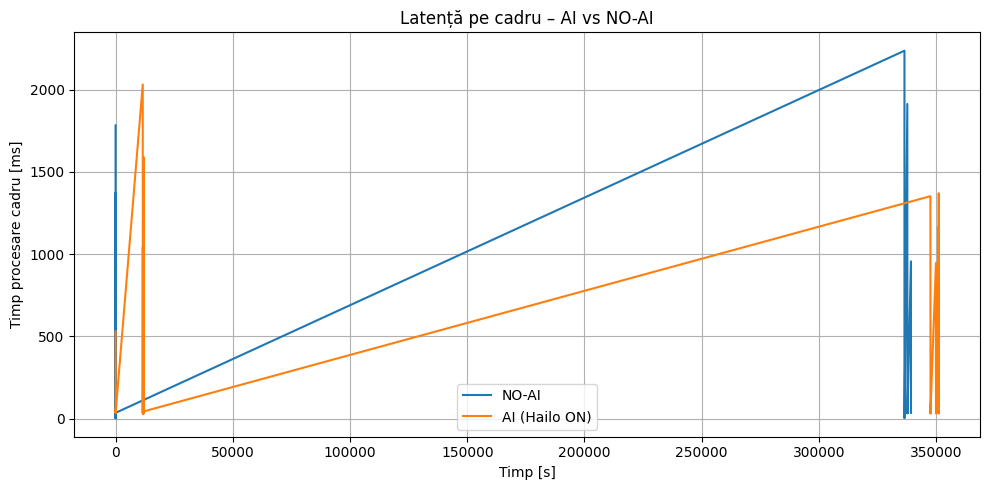

In [14]:
plt.figure()
plt.plot(df_noai["t_sec"], df_noai["frame_time_ms"], label="NO-AI")
plt.plot(df_ai["t_sec"], df_ai["frame_time_ms"], label="AI (Hailo ON)")
plt.xlabel("Timp [s]")
plt.ylabel("Timp procesare cadru [ms]")
plt.title("Latență pe cadru – AI vs NO-AI")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("compare_frame_time.png", dpi=150)
plt.show()


Distribuția comenzilor (bar chart)

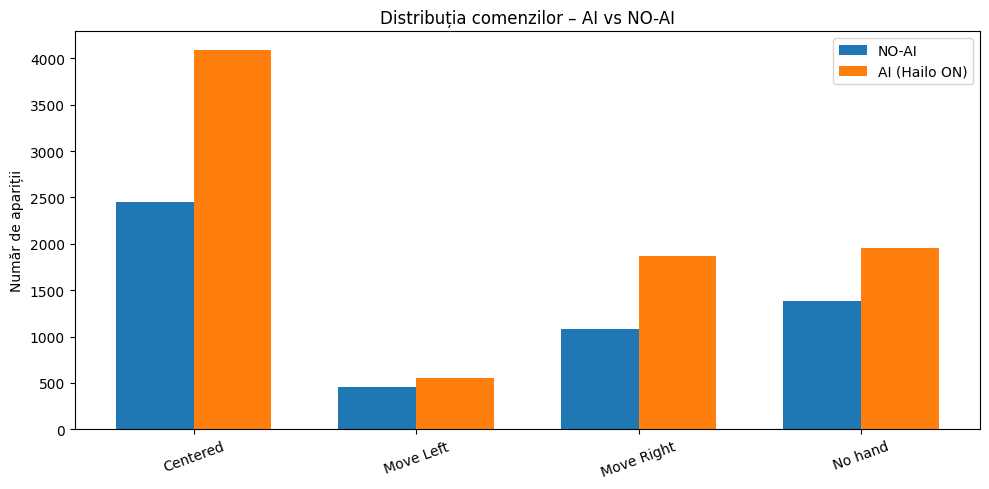

In [15]:
cmd_counts_noai = df_noai["command"].value_counts().sort_index()
cmd_counts_ai = df_ai["command"].value_counts().sort_index()

commands = sorted(set(cmd_counts_noai.index) | set(cmd_counts_ai.index))
vals_noai = [cmd_counts_noai.get(c, 0) for c in commands]
vals_ai = [cmd_counts_ai.get(c, 0) for c in commands]

x = np.arange(len(commands))
width = 0.35

plt.figure()
plt.bar(x - width/2, vals_noai, width, label="NO-AI")
plt.bar(x + width/2, vals_ai, width, label="AI (Hailo ON)")
plt.xticks(x, commands, rotation=20)
plt.ylabel("Număr de apariții")
plt.title("Distribuția comenzilor – AI vs NO-AI")
plt.legend()
plt.tight_layout()
plt.savefig("compare_command_distribution.png", dpi=150)
plt.show()


Procent „No hand” 

In [16]:
def no_hand_ratio(df):
    return (df["command"] == "No hand").mean()

r_noai = no_hand_ratio(df_noai)
r_ai = no_hand_ratio(df_ai)

print(f"Procent 'No hand' (NO-AI): {r_noai:.3f}")
print(f"Procent 'No hand' (AI):    {r_ai:.3f}")


Procent 'No hand' (NO-AI): 0.257
Procent 'No hand' (AI):    0.231


Distribuția centroidului (cx, cy)

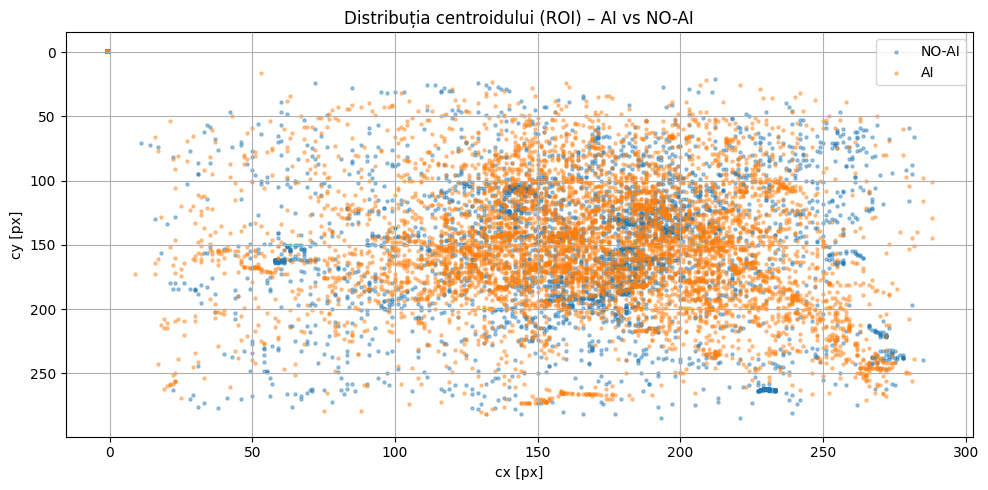

In [17]:
plt.figure()
plt.scatter(df_noai["cx"], df_noai["cy"], s=5, alpha=0.4, label="NO-AI")
plt.scatter(df_ai["cx"], df_ai["cy"], s=5, alpha=0.4, label="AI")
plt.gca().invert_yaxis()
plt.xlabel("cx [px]")
plt.ylabel("cy [px]")
plt.title("Distribuția centroidului (ROI) – AI vs NO-AI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("compare_centroid.png", dpi=150)
plt.show()


Landmark-uri MediaPipe (medie)

In [ ]:
print("Landmark-uri MediaPipe – medie per cadru:")
print(f"NO-AI: {df_noai['mediapipe_landmarks'].mean():.2f}")
print(f"AI:    {df_ai['mediapipe_landmarks'].mean():.2f}")


Tabel sumar comparativ

In [ ]:
def compute_summary(df, label):
    return {
        "Scenario": label,
        "FPS mediu": df["fps"].mean(),
        "FPS minim": df["fps"].min(),
        "FPS maxim": df["fps"].max(),
        "Latență medie [ms]": df["frame_time_ms"].mean(),
        "Latență max [ms]": df["frame_time_ms"].max(),
        "Procent 'No hand'": (df["command"]=="No hand").mean(),
        "Media landmark-uri MediaPipe": df["mediapipe_landmarks"].mean(),
        "Comenzi trimise (tcp_sent)": df["tcp_sent"].sum(),
        "Reconectări TCP": df["tcp_reconnected"].sum(),
        "Hailo score mediu": df["hailo_score"].mean(),
        "Hailo valid ratio": df["hailo_valid"].mean()
    }

summary_rows = [
    compute_summary(df_noai, "NO-AI"),
    compute_summary(df_ai, "AI (Hailo ON)")
]

summary_df = pd.DataFrame(summary_rows)
summary_df
